## Brief description of the dataset
    Frequency: Frequency of the test conditions, in Hertz.
    Angle_of_attack: Angle of attack of the airfoil, in degrees.
    Chord_length: Chord length of the airfoil, in meters.
    Free-stream_velocity: Free-stream velocity of the wind tunnel, in meters per second.
    Suction_side_thickness: Thickness of the airfoil suction side, in meters.
    Scaled_sound_pressure_level: Scaled sound pressure level, in decibels.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import normalize
from sklearn.neighbors import kneighbors_graph
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

# Load data from file
file_path = 'airfoil_self_noise.dat'
column_names = ['Frequency', 'Angle_of_attack', 'Chord_length', 'Free-stream_velocity',
                'Suction_side_thickness', 'Scaled_sound_pressure_level']
df = pd.read_csv(file_path, sep='\t', header=None, names=column_names)
display(df.head())

,Frequency,Angle_of_attack,Chord_length,Free-stream_velocity,Suction_side_thickness,Scaled_sound_pressure_level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [4]:
# Data preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

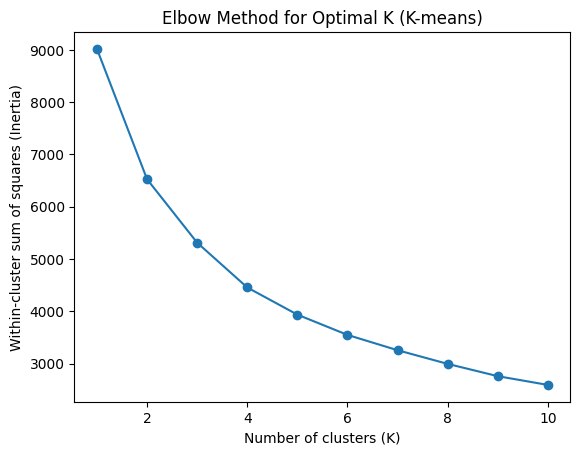

In [5]:
# Applying K-means clustering
kmeans_inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    kmeans_inertia.append(kmeans.inertia_)

# Plotting the elbow curve to find the suitable choice of K for K-means
plt.plot(range(1, 11), kmeans_inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-cluster sum of squares (Inertia)')
plt.title('Elbow Method for Optimal K (K-means)')
plt.show()

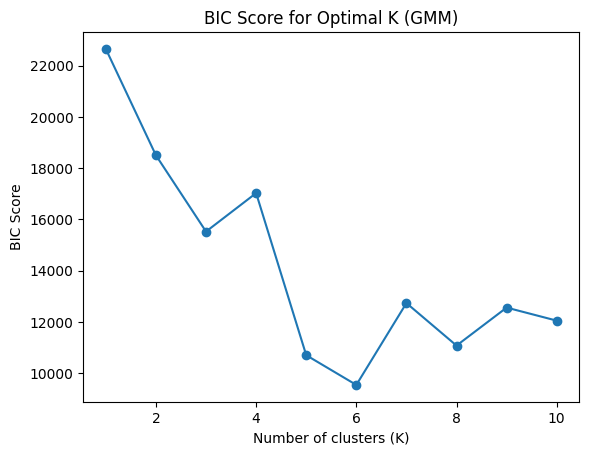

In [6]:
# Applying Gaussian Mixture Model (GMM) clustering
bic_scores = []
for k in range(1, 11):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(scaled_data)
    bic_scores.append(gmm.bic(scaled_data))

# Plotting the BIC scores to find the suitable choice of K for GMM
plt.plot(range(1, 11), bic_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('BIC Score')
plt.title('BIC Score for Optimal K (GMM)')
plt.show()

In [7]:
# K-means clustering with K=4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

# GMM clustering with K=2
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(scaled_data)

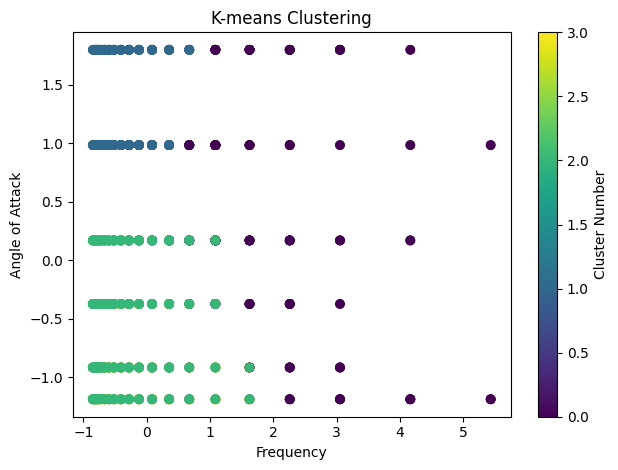

In [12]:
# Plotting K-means clusters
plt.scatter(scaled_data[:, 0], scaled_data[:, 2], c=kmeans_labels, cmap='viridis')
plt.title('K-means Clustering')
plt.xlabel('Frequency')
plt.ylabel('Chord Length')
plt.tight_layout()
plt.colorbar(label='Cluster Number')
plt.show()

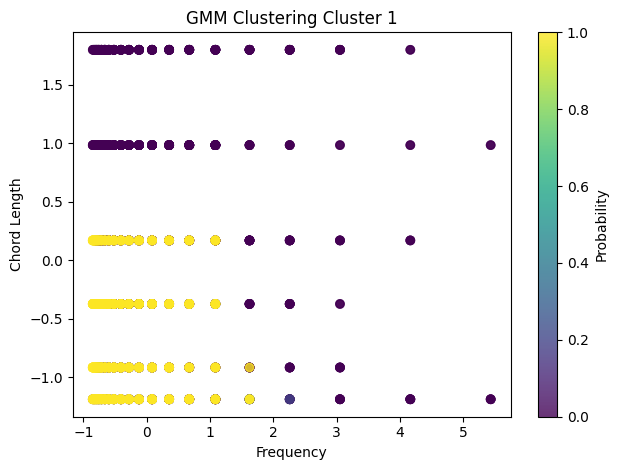

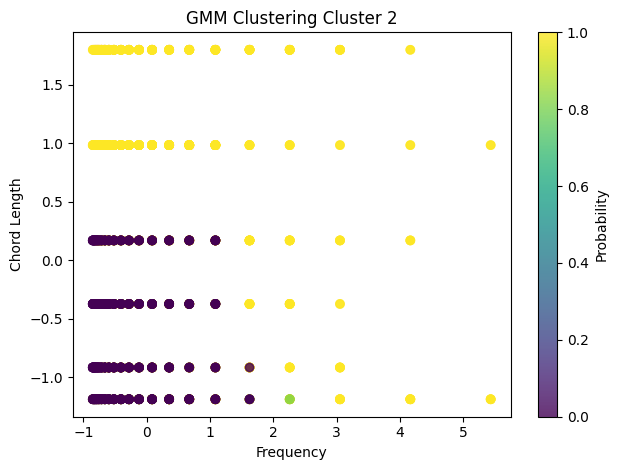

In [13]:
# Plotting GMM clusters
for i in range(len(gmm.means_)):
    probs = gmm.predict_proba(scaled_data)
    plt.scatter(scaled_data[:, 0], scaled_data[:, 2], c=probs[:, i], cmap='viridis', alpha=0.8)
    plt.colorbar(label='Probability')
    plt.title(f'GMM Clustering Cluster {i+1}')
    plt.xlabel('Frequency')
    plt.ylabel('Chord Length')
    plt.tight_layout()
    plt.show()

In [16]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
df_reduced = pca.fit_transform(scaled_data)
df_red = pd.DataFrame(df_reduced, columns=['PC_1', 'PC_2'])
display(df_red.head())

# Normalize the reduced data
normalized_reduced_data = normalize(df_reduced)
df_normalized = pd.DataFrame(normalized_reduced_data, columns=['PC_1', 'PC_2'])
display(df_normalized.head())

,PC_1,PC_2
0,-1.698068,-0.318120
1,-1.701283,-0.171817
2,-1.730668,-0.215102
3,-1.779290,-0.342421
4,-1.809437,-0.261278


,PC_1,PC_2
0,-0.982900,-0.184139
1,-0.994939,-0.100481
2,-0.992365,-0.123340
3,-0.981981,-0.188980
4,-0.989735,-0.142915


In [17]:
variance_of_each_column = df_normalized.var()

# Display the variance of each column
print("Variance of each column:")
print(variance_of_each_column)

Variance of each column:
PC_1    0.556128
PC_2    0.416487
dtype: float64


# Spectral Clustering on Reduced Dataset(Using PCA)

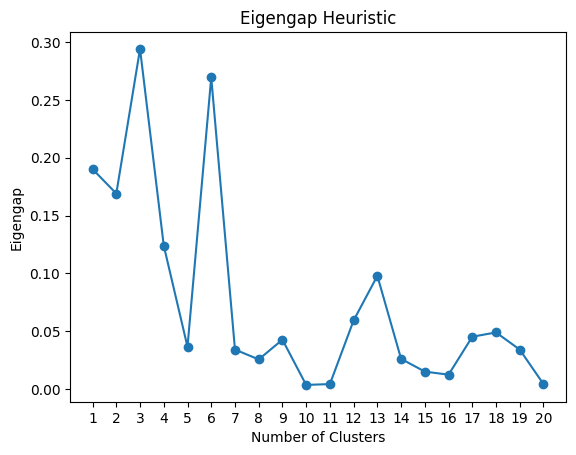

3


In [18]:
from sklearn.neighbors import kneighbors_graph

similarity_matrix = kneighbors_graph(df_red, n_neighbors=10, mode='connectivity', include_self=True)
similarity_matrix = similarity_matrix.toarray()
degree_matrix = np.diag(np.sum(similarity_matrix, axis=1))
laplacian_matrix = degree_matrix - similarity_matrix
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues = eigenvalues[sorted_indices]
eigengaps = np.diff(sorted_eigenvalues)
eigengaps = eigengaps[:20]
optimal_k_index = np.argmax(eigengaps)

# Plot eigengaps
plt.plot(range(1, len(eigengaps) + 1), eigengaps, marker='o')
plt.title('Eigengap Heuristic')
plt.xlabel('Number of Clusters')
plt.ylabel('Eigengap')
plt.xticks(np.arange(1, len(eigengaps) + 1, step=1))  # Adjust step value as needed
plt.show()

optimal_k = optimal_k_index + 1
print(optimal_k)

### a) Using nearest_neighbours

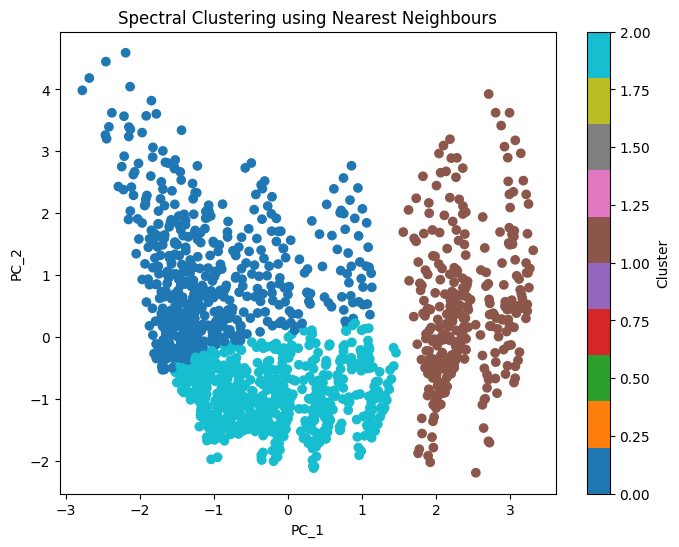

In [19]:
from sklearn.cluster import SpectralClustering
spectral_clustering = SpectralClustering(n_clusters=optimal_k, affinity='nearest_neighbors')

# Fit and predict cluster labels
nn_labels = spectral_clustering.fit_predict(df_red)

plt.figure(figsize=(8, 6))
plt.scatter(df_red['PC_1'], df_red['PC_2'], c=nn_labels, cmap='tab10')
plt.title('Spectral Clustering using Nearest Neighbours')
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.colorbar(label='Cluster')
plt.show()

### b) Using rbf

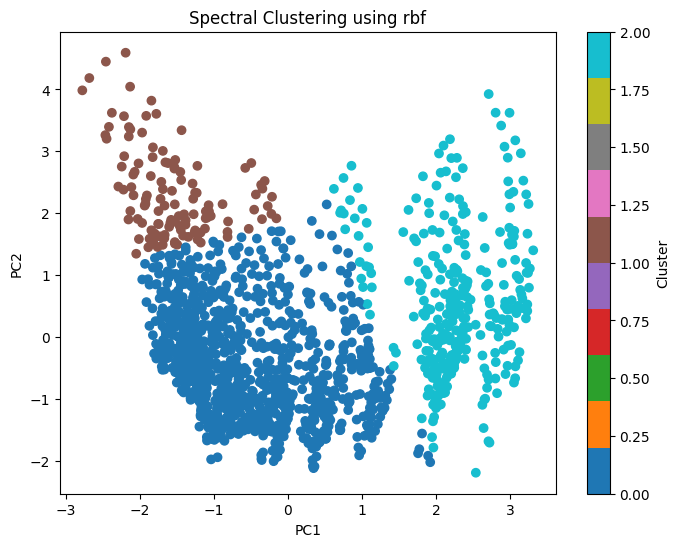

In [20]:
from sklearn.cluster import SpectralClustering
spectral_clustering = SpectralClustering(n_clusters=optimal_k, affinity='rbf')

# Fit and predict cluster labels
rbf_labels = spectral_clustering.fit_predict(df_red)

plt.figure(figsize=(8, 6))
plt.scatter(df_red['PC_1'], df_red['PC_2'], c=rbf_labels, cmap='tab10')
plt.title('Spectral Clustering using rbf')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

### Comparing results using Silhouette Score

Silhouette Score for 'nearest_neighbors' affinity: 0.4174482490186562
Silhouette Score for 'rbf' affinity: 0.43962899867753247


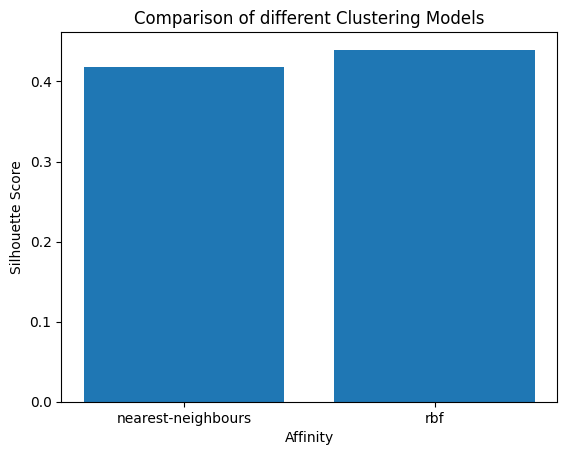

In [21]:
affinity = ['nearest-neighbours', 'rbf']

s_scores = []
s_scores.append(silhouette_score(df_red, nn_labels))
s_scores.append(silhouette_score(df_red, rbf_labels))

print("Silhouette Score for 'nearest_neighbors' affinity:", s_scores[0])
print("Silhouette Score for 'rbf' affinity:", s_scores[1])

# Plotting Bar Graph to compare the Models
plt.bar(affinity, s_scores)
plt.xlabel('Affinity')
plt.ylabel('Silhouette Score')
plt.title('Comparison of different Clustering Models')
plt.show()

# Spectral Clustering on Normalised Dataset

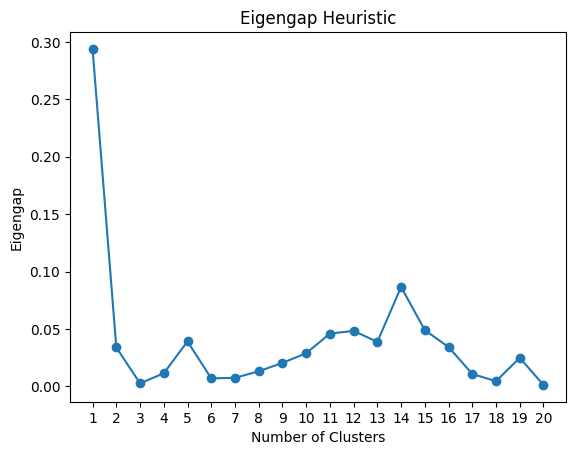

14


In [31]:
from sklearn.neighbors import kneighbors_graph

similarity_matrix = kneighbors_graph(df_normalized, n_neighbors=10, mode='connectivity', include_self=True)

similarity_matrix = similarity_matrix.toarray()
degree_matrix = np.diag(np.sum(similarity_matrix, axis=1))
laplacian_matrix = degree_matrix - similarity_matrix
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues = eigenvalues[sorted_indices]
eigengaps = np.diff(sorted_eigenvalues)
eigengaps = eigengaps[:20]
optimal_k_index = np.argmax(eigengaps)
# Check if optimal_k_index is 0
if optimal_k_index == 0:
    optimal_k_index = np.argsort(eigengaps)[-2]  # Second highest eigengap

# Plot eigengaps
plt.plot(range(1, len(eigengaps) + 1), eigengaps, marker='o')
plt.title('Eigengap Heuristic')
plt.xlabel('Number of Clusters')
plt.ylabel('Eigengap')
plt.xticks(np.arange(1, len(eigengaps) + 1, step=1))  # Adjust step value as needed
plt.show()

optimal_k = optimal_k_index + 1
print(optimal_k)

### a) Using Nearest Neighbours

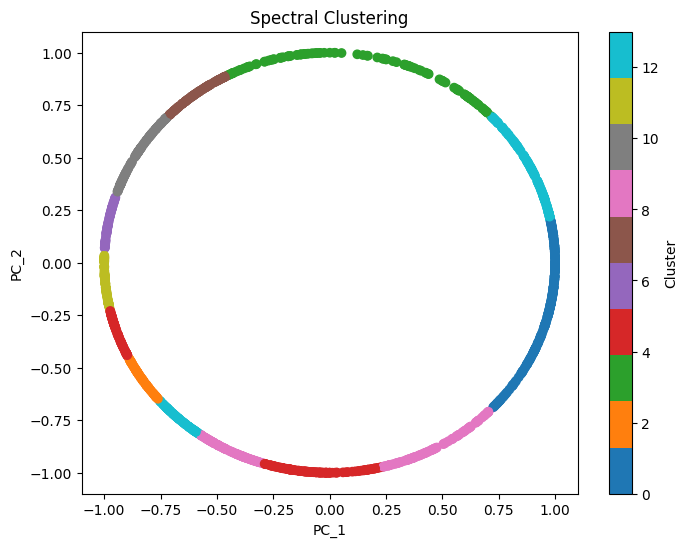

In [32]:
from sklearn.cluster import SpectralClustering
spectral_clustering = SpectralClustering(n_clusters=optimal_k, affinity='nearest_neighbors')
nn_labels = spectral_clustering.fit_predict(df_normalized)

plt.figure(figsize=(8, 6))
plt.scatter(df_normalized['PC_1'], df_normalized['PC_2'], c=nn_labels, cmap='tab10')
plt.title('Spectral Clustering')
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.colorbar(label='Cluster')
plt.show()

### b) Using rbf

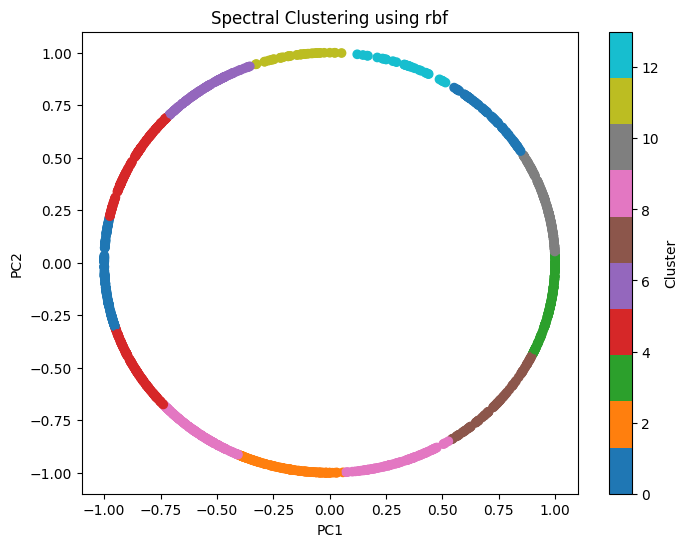

In [33]:
from sklearn.cluster import SpectralClustering
spectral_clustering = SpectralClustering(n_clusters=optimal_k, affinity='rbf')
rbf_labels = spectral_clustering.fit_predict(df_normalized)

plt.figure(figsize=(8, 6))
plt.scatter(df_normalized['PC_1'], df_normalized['PC_2'], c=rbf_labels, cmap='tab10')
plt.title('Spectral Clustering using rbf')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

### Comparing the models using Silhouette Score

Silhouette Score for 'nearest_neighbors' affinity: 0.46637069961440997
Silhouette Score for 'rbf' affinity: 0.45746252480719607


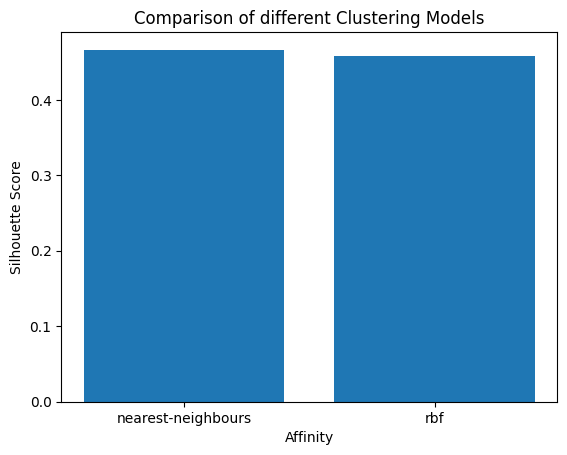

In [34]:
affinity = ['nearest-neighbours', 'rbf']
s_scores = []
s_scores.append(silhouette_score(df_normalized, nn_labels))
s_scores.append(silhouette_score(df_normalized, rbf_labels))
print("Silhouette Score for 'nearest_neighbors' affinity:", s_scores[0])
print("Silhouette Score for 'rbf' affinity:", s_scores[1])

# Plotting Bar Graph to compare the Models
plt.bar(affinity, s_scores)
plt.xlabel('Affinity')
plt.ylabel('Silhouette Score')
plt.title('Comparison of different Clustering Models')
plt.show()